In [2]:
from simpegEMIP.StretchedExponential import SE_MultiInvProblem, SE_MultiSurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from SimPEG import Mesh, Utils, Maps, DataMisfit, Optimization, Inversion, InvProblem, Directives, Regularization
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
nLoc = 100
wires = Maps.Wires(('eta', nLoc), ('tau', nLoc), ('c', nLoc))
taumap = Maps.ExpMap(nP=nLoc)*wires.tau

time = np.logspace(-3, 0, 31)
m1D = Mesh.TensorMesh([np.ones(nLoc)])
xyz = np.arange(nLoc)
survey = SE_MultiSurvey(time, xyz)
prob = SE_MultiInvProblem(m1D, etaMap = wires.eta, tauMap = taumap, cMap=wires.c)
prob.pair(survey)

eta0, tau0, c0 = np.zeros(nLoc), 0.3*np.ones(nLoc), 0.5*np.ones(nLoc)
eta, tau, c = np.random.randn(nLoc), 0.5*np.ones(nLoc), 1*np.ones(nLoc)
m0 = np.r_[eta0, np.log(tau0), c0]
m = np.r_[eta, np.log(tau), c]
dpred = survey.makeSyntheticData(m, std=0.01)

In [4]:
mreg = Mesh.TensorMesh([len(m)])
dmisfit = DataMisfit.l2_DataMisfit(survey)
reg = Regularization.BaseRegularization(mreg)
opt = Optimization.ProjectedGNCG(maxIter = 100)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
target = Directives.TargetMisfit()
betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
invProb.beta = 0.
inv = Inversion.BaseInversion(invProb, directiveList=[betaSch, target])
reg.mref = 0.*m0
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
opt.tolX = 1e-20
opt.tolF = 1e-20
opt.tolG = 1e-20
opt.eps = 1e-20
# opt.lower = 0.
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
   0  0.00e+00  1.17e+07  8.50e+01  1.17e+07    4.36e+06      0              
   1  0.00e+00  5.84e+06  9.00e+01  5.84e+06    3.93e+06      0              
   2  0.00e+00  3.96e+06  9.23e+01  3.96e+06    1.90e+06      0              
   3  0.00e+00  2.62e+06  1.05e+02  2.62e+06    2.09e+06      0   Skip BFGS  
   4  0.00e+00  2.04e+06  1.02e+02  2.04e+06    1.65e+06      0              
   5  0.00e+00  1.68e+06  1.10e+02  1.68e+06    1.83e+06      0              
   6  0.00e+00  1.21e+06  1.18e+02  

In [5]:
target.target

1550.0

(0.001, 10)

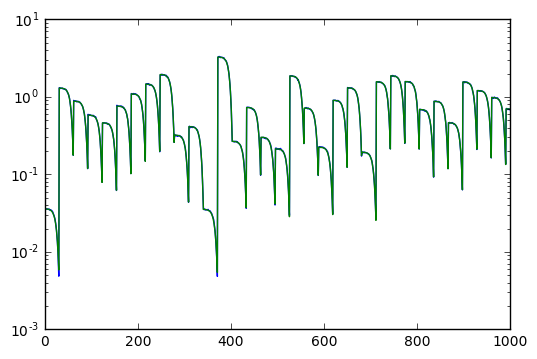

In [6]:
plt.semilogy(abs(survey.dobs))
plt.semilogy(abs(invProb.dpred))
plt.xlim(0, 1000)
plt.ylim(1e-3, 10)

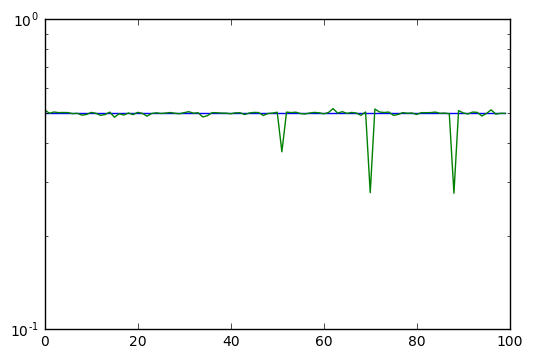

In [7]:
plt.semilogy(tau)
plt.semilogy(taumap * mopt)